In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Use GPU if available
is_cuda = torch.cuda.is_available()

if is_cuda:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(is_cuda)

True


In [3]:
# Early stopping class to prevent overfitting https://gist.github.com/sinecode/df13c3110be2e6f7bab8de294f756227
class EarlyStopping:
    def __init__(self, patience=3, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

In [4]:
# LSTM Regression model inspired by https://github.com/ritchieng/deep-learning-wizard/blob/master/docs/deep_learning/practical_pytorch/pytorch_lstm_neuralnetwork.md
class LSTMRegression(nn.Module):
    # Default values if none provided
    def __init__(self, input_size, hidden_size=50, num_layers=2, output_size=1, dropout=0.5):
        super().__init__()
        # Create hidden layers as specified in parameters
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        # Add dropout
        self.dropout = nn.Dropout(dropout)
        # Add linear layer for output
        self.linear = nn.Linear(hidden_size, output_size)

    
    def forward(self, x):
        # Instance of LSTM
        out, _ = self.lstm(x)
        # Add dropout and take last step's output
        out = self.dropout(out[:, -1, :])
        # Fullt connected linear layer for output
        out = self.linear(out)
        return out

In [5]:
def get_train_test(site_name, minute_shift, drop_timestamps=True):
    # 15, 60, and 1440 are the only valid look forward windows
    if minute_shift in ['15', '60', '1440']:
        # A and B are the only valid site names
        if site_name in ['A', 'B']:
            # Read CSV for specific site
            df = pd.read_csv(f"SunLab_Faro_Cleaned_{site_name}_features.csv", parse_dates=['Datetime'])

            # Drop other two look forward windoes
            for minute_shift_drop in ['15', '60', '1440']:
                if minute_shift_drop != minute_shift:
                    # Drop minute shift values not specified
                    df.drop(columns=[f"{site_name}_Optimal - Power DC [W]_shift_{minute_shift_drop}"], inplace=True)

            df.set_index('Datetime', inplace=True)
            # Resample daily shift to 15 minute average and 60 minute shift to 5 minutes
            if minute_shift == '1440':
                df = df.resample('15min').mean()
            elif minute_shift == '60':
                df = df.resample('5min').mean()

            df.reset_index(inplace=True)

            #  drop NaN if exists
            df.dropna(inplace=True)

            # Keep last year for test
            test_split = pd.to_datetime("1/1/2017")

            # Save for training
            df_train = df.loc[df['Datetime'] < test_split].copy()

            # Save for testing
            df_test = df.loc[df['Datetime'] >= test_split].copy()

            if drop_timestamps: 
                df_train.drop(columns=['Datetime'], inplace=True)
                df_test.drop(columns=['Datetime'], inplace=True)
        else:
            raise(f"invalid site_name {site_name}, must be 'A' or 'B'")
    else:
        raise(f"invalid minute_shift {minute_shift}, must be '15', '60', or '1440'")

    return df_train, df_test 


In [6]:
def train_model(df_train, df_test, y_col_name, X_col_names, sequence_length=20, batch_size=2048, do_verbose=True, num_layers=3, \
                hidden_size=50, do_linear=False, cross_validation_splits=1, return_data=False):
    # Convert dataframe to numpy
    X_train = df_train[X_col_names].copy().to_numpy()
    y_train = df_train[y_col_name].copy().values

    X_sequences_train = []
    y_sequences_train = []

    for i in range(len(df_train) - sequence_length):
        X_sequences_train.append(X_train[i:i+sequence_length])
        # Since the last value in the sequence has the shifted target value, append only this
        y_sequences_train.append(y_train[i+sequence_length])

    # Convert dataframe to numpy
    X_test = df_test[X_col_names].copy().to_numpy()
    y_test = df_test[y_col_name].copy().values

    X_sequences_test = []
    y_sequences_test = []

    for i in range(len(df_test) - sequence_length):
        X_sequences_test.append(X_test[i:i+sequence_length])
        # Since the last value in the sequence has the shifted target value, append only this
        y_sequences_test.append(y_test[i+sequence_length])

    # Convert list into tensors
    X_sequences_train = torch.FloatTensor(X_sequences_train)
    y_sequences_train = torch.FloatTensor(y_sequences_train)
    X_sequences_test = torch.FloatTensor(X_sequences_test)
    y_sequences_test = torch.FloatTensor(y_sequences_test)

    # Normalize features
    scaler = StandardScaler()
    X_scaled_train = scaler.fit_transform(X_sequences_train.reshape(-1, len(X_col_names)))
    X_scaled_train = X_scaled_train.reshape(-1, sequence_length, len(X_col_names))
    X_sequences_train = torch.FloatTensor(X_scaled_train)

    # Do not fit again, keep fit from training data
    X_scaled_test = scaler.transform(X_sequences_test.reshape(-1, len(X_col_names)))
    X_scaled_test = X_scaled_test.reshape(-1, sequence_length, len(X_col_names))
    X_sequences_test = torch.FloatTensor(X_scaled_test)

    avg_test_loss = 0.0
    for i in range(cross_validation_splits):
        if do_verbose: print(f"Starting training loop {i} of {np.max(range(cross_validation_splits))}")
        # if cross_validation_splits is 1, we are only doing a single run.  Otherwise split data into n splits
        if cross_validation_splits == 1:
            train_X, val_X, train_y, val_y = train_test_split(X_sequences_train, y_sequences_train, test_size=0.2, shuffle=False)
        else:
            split_size = int(len(y_sequences_train) / cross_validation_splits)
            if do_verbose: print(f"Split size={split_size}")

            # Starting and stopping points for splits
            split_start = i * split_size
            split_end = (i + 1) * split_size
            
            # Validation will always be a single split of total training list
            val_X = X_sequences_train[split_start:split_end,:,:]
            val_y = y_sequences_train[split_start:split_end]
            
            # Training splits will be on either side of the validation split, except the first time where split_start == 0
            # Concat to single torch tensor
            train_X_1 = X_sequences_train[:split_start,:,:]
            train_X_2 = X_sequences_train[split_end:,:,:]
            train_X = torch.cat((train_X_1, train_X_2), dim=0)

            train_y_1 = y_sequences_train[:split_start,]
            train_y_2 = y_sequences_train[split_end:]
            train_y = torch.cat((train_y_1, train_y_2), dim=0)
            
            if do_verbose: print(f"split_start={split_start} split_end={split_end}")

        # DataLoaders
        train_loader = DataLoader(list(zip(train_X, train_y)), batch_size=batch_size)
        val_loader = DataLoader(list(zip(val_X, val_y)), batch_size=batch_size)
        test_loader = DataLoader(list(zip(X_sequences_test, y_sequences_test)), batch_size=batch_size)

        # Provide option to run basic linear regression for baseline
        if do_linear:
            model = LinearRegression()
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            avg_test_loss += mean_squared_error(y_test, y_pred)
        # If not linear, do LSTM using PyTorch
        else:
            # Initialize model and training parameters
            input_size = len(X_col_names)
            model = LSTMRegression(input_size=input_size, num_layers=num_layers, hidden_size=hidden_size).to(device)
            criterion = nn.MSELoss()
            optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

            # Enable early stopping after 10 worse results
            early_stopping = EarlyStopping(patience=10)

            n_epochs = 1000
            for epoch in range(n_epochs):
                train_loss = 0.0
                model.train()
                # Training loop, get train loss
                for i, (inputs, labels) in enumerate(train_loader):
                    optimizer.zero_grad()
                    outputs = model(inputs.to(device))
                    loss = criterion(outputs.squeeze(), labels.to(device))
                    train_loss += loss
                    loss.backward()
                    optimizer.step()
                avg_train_loss = train_loss / len(train_loader)
                
                model.eval()
                val_loss = 0.0
                # Validation loop, get validation loss
                with torch.no_grad():
                    for inputs_val, labels_val in val_loader:
                        outputs_val = model(inputs_val.to(device))
                        val_loss += criterion(outputs_val.squeeze(), labels_val.to(device)).item()
                    avg_val_loss = val_loss / len(val_loader)
                
                if do_verbose: print(f'Epoch {epoch+1}/{n_epochs}, Train Loss: {avg_train_loss:.2f} Val Loss: {avg_val_loss:.2f}')

                # Early stop based on validation loss
                early_stopping(avg_val_loss)
                if early_stopping.early_stop:
                    if do_verbose: print("Early stopping triggered")
                    break

            # Loop over test dataloader
            test_loss = 0.0
            # Test against unseen data
            with torch.no_grad():
                for inputs_test, labels_test in test_loader:
                    outputs_test = model(inputs_test.to(device))
                    test_loss += criterion(outputs_test.squeeze(), labels_test.to(device)).item()
                avg_test_loss += test_loss / len(test_loader)

            if do_verbose: print(f'Test Loss: {test_loss / len(test_loader):.2f}')
    # Test loss sums up from each cross validation split, get average
    if return_data:
        with torch.no_grad():
            predictions = model(X_sequences_test.to(device))
            return y_sequences_test, predictions, (avg_test_loss/cross_validation_splits)
    else:
        return(avg_test_loss/cross_validation_splits)


In [8]:
site_name = 'A'

# Starting loss values for LSTM
start_loss_dict_lstm = {}

# Starting loss values for scikit-learn regression
start_loss_dict_sk = {}

for minute_shift in ['15', '60', '1440']:
    df_train, df_test = get_train_test(site_name=site_name, minute_shift=minute_shift)

    # Value we are predicting
    y_col_name = f"{site_name}_Optimal - Power DC [W]_shift_{minute_shift}"
    X_col_names = df_train.columns.to_list()
    X_col_names.remove(y_col_name)

    # Get linear regression loss before hyper-parameter tuning or removing any features
    start_loss_dict_sk[minute_shift] = train_model(df_train, df_test, y_col_name, X_col_names, do_verbose=False,\
                                                do_linear=True, cross_validation_splits=5)

    # Get LSTM loss before hyper-parameter tuning or removing any features
    start_loss_dict_lstm[minute_shift] = train_model(df_train, df_test, y_col_name, X_col_names, do_verbose=False,\
                                                cross_validation_splits=5)
    
    print(f"!!!! Starting loss for{minute_shift} scikit-learn {start_loss_dict_sk[minute_shift]:.2f} and lstm {start_loss_dict_lstm[minute_shift]:.2f}")

    result_dict = {}
    # Grid search sequence lenghts
    for sequence_length in [3, 5, 10, 15, 20]:
        iter_test_loss = 0
        result_dict[sequence_length] = train_model(df_train, df_test, y_col_name, X_col_names, do_verbose=False,\
                                                sequence_length=sequence_length, cross_validation_splits=5)
        print(f"minute_shift={minute_shift} sequence_length={sequence_length} loss={result_dict[sequence_length]:.2f}")
    # https://stackoverflow.com/questions/3282823/get-the-key-corresponding-to-the-minimum-value-within-a-dictionary
    # Get best sequence length
    sequence_length = min(result_dict, key=result_dict.get)
    print(f"Best sequence_length={sequence_length}")

    result_dict = {}
    # Grid search number of layers in network
    for num_layers in [2, 3, 4, 5, 6]:
        result_dict[num_layers] = train_model(df_train, df_test, y_col_name, X_col_names, do_verbose=False,\
                                            num_layers=num_layers, cross_validation_splits=5, sequence_length=sequence_length)
        print(f"minute_shift={minute_shift} num_layers size={num_layers} loss={result_dict[num_layers]:.2f}")
    num_layers = min(result_dict, key=result_dict.get)
    print(f"Best num_layers={num_layers}")

    result_dict = {}
    # Grid search batch size
    for batch_size in [512, 1024, 2048, 4096, 8192, 16384]:
        result_dict[batch_size] = train_model(df_train, df_test, y_col_name, X_col_names, do_verbose=False,\
                                            batch_size=batch_size, cross_validation_splits=5, sequence_length=sequence_length, num_layers=num_layers)
        print(f"minute_shift={minute_shift} batch size={batch_size} loss={result_dict[batch_size]:.2f}")
    batch_size = min(result_dict, key=result_dict.get)
    print(f"Best batch_size={batch_size}")

    # Starting loss including all X features for feature grid search
    start_test_loss = train_model(df_train, df_test, y_col_name, X_col_names, do_verbose=False, cross_validation_splits=5,\
                                sequence_length=sequence_length, num_layers=num_layers, batch_size=batch_size)
    print(f"Starting loss={start_test_loss:.2f}")

    # Start with full list of features in X, remove them one by one and see if performance improves
    # If performance improves, remove feature from x feature list and try again
    # Exit loop after starting MSE is lower than all other MSEs
    while True:
        # List of loss values obtained when iterating through features
        test_loss_list = []
        for i in range(len(X_col_names)):
            # Reset feature list and delete specific feature
            X_col_names_iter = X_col_names.copy()
            del X_col_names_iter[i]
            print(f"Training with feature '{X_col_names[i]}' removed")
            iter_test_loss = train_model(df_train, df_test, y_col_name, X_col_names_iter, do_verbose=False, cross_validation_splits=5,\
                                        sequence_length=sequence_length, num_layers=num_layers, batch_size=batch_size)
            test_loss_list.append(iter_test_loss)
            print(f"-->Iteration loss={test_loss_list[-1]:.2f}")

        X_col_names_copy = X_col_names.copy()
        # If the lowest MSE is better than starting MSE, the model improved by removing the feature
        if np.min(test_loss_list) < start_test_loss:
            # https://stackoverflow.com/questions/2474015/getting-the-index-of-the-returned-max-or-min-item-using-max-min-on-a-list
            index_min = np.argmin(test_loss_list)
            print(f"Dropping feature '{X_col_names[index_min]}'")
            del X_col_names_copy[index_min]
            # New best MSE
            start_test_loss = np.min(test_loss_list)
            # Save previous best
            X_col_names_last_best = X_col_names.copy()
             # Reset featue list
            X_col_names = X_col_names_copy.copy()
        else:
            print("No more improvements, finish feature grid search")
            # Since last feature removal didn't improve, use previous best feature list
            X_col_names = X_col_names_last_best.copy()
            break

    print(f"minute_shift={minute_shift} sequence_length={sequence_length} num_layers={num_layers} batch_size={batch_size}")
    print(X_col_names)

!!!! Starting loss for15 scikit-learn 585.80 and lstm 561.91
minute_shift=15 sequence_length=3 loss=555.45
minute_shift=15 sequence_length=5 loss=561.47
minute_shift=15 sequence_length=10 loss=561.47
minute_shift=15 sequence_length=15 loss=545.86
minute_shift=15 sequence_length=20 loss=546.77
Best sequence_length=15
minute_shift=15 num_layers size=2 loss=548.00
minute_shift=15 num_layers size=3 loss=542.30
minute_shift=15 num_layers size=4 loss=585.79
minute_shift=15 num_layers size=5 loss=1514.05
minute_shift=15 num_layers size=6 loss=5097.46
Best num_layers=3
minute_shift=15 batch size=512 loss=558.28
minute_shift=15 batch size=1024 loss=540.46
minute_shift=15 batch size=2048 loss=547.98
minute_shift=15 batch size=4096 loss=581.50
minute_shift=15 batch size=8192 loss=587.54
minute_shift=15 batch size=16384 loss=3247.02
Best batch_size=1024
Starting loss=541.23
Training with feature 'A_Optimal - Voltage DC [V]' removed
-->Iteration loss=551.90
Training with feature 'A_Optimal - Curren

15 Minute shift

minute_shift=15 sequence_length=15 num_layers=3 batch_size=1024

['A_Optimal - Voltage DC [V]', 'A_Optimal - Current DC [A]', 'A_Optimal - Power DC [W]', 'A_Optimal - Temperature [C]', 'Ambient Temperature [C]', 'Ultraviolet [W/m2]', 'Wind Velocity [m/s]', 'Wind Direction [Deg]', 'Precipitation [mm]', 'day_of_year', 'hour_and_minute']



60 Minute shift

minute_shift=60 sequence_length=3 num_layers=2 batch_size=16384

['A_Optimal - Voltage DC [V]', 'A_Optimal - Current DC [A]', 'A_Optimal - Power DC [W]', 'A_Optimal - Temperature [C]', 'Ambient Temperature [C]', 'Ultraviolet [W/m2]', 'Wind Velocity [m/s]', 'Wind Direction [Deg]', 'Precipitation [mm]', 'day_of_year', 'hour_and_minute']



1440 minute shift

minute_shift=1440 sequence_length=3 num_layers=6 batch_size=2048

['A_Optimal - Voltage DC [V]', 'A_Optimal - Current DC [A]', 'A_Optimal - Power DC [W]', 'A_Optimal - Temperature [C]', 'Ambient Temperature [C]', 'Global Radiation [W/m2]', 'Ultraviolet [W/m2]', 'Wind Velocity [m/s]', 'Wind Direction [Deg]', 'day_of_year', 'hour_and_minute']

In [9]:
# Optimal features and hyperparameters for 15 minute look ahead
X_col_15 = ['A_Optimal - Voltage DC [V]', 'A_Optimal - Current DC [A]', 'A_Optimal - Power DC [W]', 'A_Optimal - Temperature [C]', 'Ambient Temperature [C]',\
            'Ultraviolet [W/m2]', 'Wind Velocity [m/s]', 'Wind Direction [Deg]', 'Precipitation [mm]', 'day_of_year', 'hour_and_minute']
sequence_length_15 = 15
num_layers_15 = 3
batch_size_15 = 1024

# Optimal features and hyperparameters for 60 minute look ahead
X_col_60 = ['A_Optimal - Voltage DC [V]', 'A_Optimal - Current DC [A]', 'A_Optimal - Power DC [W]', 'A_Optimal - Temperature [C]', 'Ambient Temperature [C]',\
            'Ultraviolet [W/m2]', 'Wind Velocity [m/s]', 'Wind Direction [Deg]', 'Precipitation [mm]', 'day_of_year', 'hour_and_minute']
sequence_length_60 = 3
num_layers_60 = 2
batch_size_60 = 16384

# Optimal features and hyperparameters for 1 day look ahead
X_col_1440 = ['A_Optimal - Voltage DC [V]', 'A_Optimal - Current DC [A]', 'A_Optimal - Power DC [W]', 'A_Optimal - Temperature [C]', 'Ambient Temperature [C]',\
              'Global Radiation [W/m2]', 'Ultraviolet [W/m2]', 'Wind Velocity [m/s]', 'Wind Direction [Deg]', 'day_of_year', 'hour_and_minute']
sequence_length_1440 = 3
num_layers_1440 = 6
batch_size_1440 = 2048

In [10]:
# Get train and test data, keep timestamps for later
df_train_15, df_test_15 = get_train_test(site_name='A', minute_shift='15', drop_timestamps=False)

# Split out timestamps
df_train_15_timestamp = df_train_15['Datetime'].copy()
df_train_15.drop(columns=['Datetime'], inplace=True)
df_test_15_timestamp = df_test_15['Datetime'].copy()
df_test_15.drop(columns=['Datetime'], inplace=True)

# Value being predicted
y_col_name_15 = f"A_Optimal - Power DC [W]_shift_15"
# Get simple regression loss
linear_loss_15 = train_model(df_train_15, df_test_15, y_col_name_15, X_col_15, do_verbose=False, do_linear=True,cross_validation_splits=5)
# Get LSTM loss
lstm_true_15, lstm_pred_15, lstm_loss_15 = train_model(df_train_15, df_test_15, y_col_name_15, X_col_15, do_verbose=False, do_linear=False,\
                                                cross_validation_splits=5, sequence_length=sequence_length_15,\
                                                num_layers=num_layers_15, batch_size=batch_size_15, return_data=True)

In [11]:
# Get train and test data, keep timestamps for later
df_train_60, df_test_60  = get_train_test(site_name='A', minute_shift='60', drop_timestamps=False)

# Split out timestamps
df_train_60_timestamp = df_train_60['Datetime'].copy()
df_train_60.drop(columns=['Datetime'], inplace=True)
df_test_60_timestamp = df_test_60['Datetime'].copy()
df_test_60.drop(columns=['Datetime'], inplace=True)

# Value being predicted
y_col_name_60 = f"A_Optimal - Power DC [W]_shift_60"
# Get simple regression loss
linear_loss_60 = train_model(df_train_60, df_test_60, y_col_name_60, X_col_60, do_verbose=False, do_linear=True,cross_validation_splits=5)
# Get LSTM loss
lstm_true_60, lstm_pred_60, lstm_loss_60 = train_model(df_train_60, df_test_60, y_col_name_60, X_col_60, do_verbose=False, do_linear=False,\
                                                cross_validation_splits=5, sequence_length=sequence_length_60,\
                                                num_layers=num_layers_60, batch_size=batch_size_60, return_data=True)

In [12]:
# Get train and test data, keep timestamps for later
df_train_1440, df_test_1440  = get_train_test(site_name='A', minute_shift='1440', drop_timestamps=False)

# Split out timestamps
df_train_1440_timestamp = df_train_1440['Datetime'].copy()
df_train_1440.drop(columns=['Datetime'], inplace=True)
df_test_1440_timestamp = df_test_1440['Datetime'].copy()
df_test_1440.drop(columns=['Datetime'], inplace=True)

# Value being predicted
y_col_name_1440 = f"A_Optimal - Power DC [W]_shift_1440"
# Get simple regression loss
linear_loss_1440 = train_model(df_train_1440, df_test_1440, y_col_name_1440, X_col_1440, do_verbose=False, do_linear=True,cross_validation_splits=5)
# Get LSTM loss
lstm_true_1440, lstm_pred_1440, lstm_loss_1440 = train_model(df_train_1440, df_test_1440, y_col_name_1440, X_col_1440, do_verbose=False, do_linear=False,\
                                                cross_validation_splits=5, sequence_length=sequence_length_1440,\
                                                num_layers=num_layers_1440, batch_size=batch_size_1440, return_data=True)

In [13]:
print(f"linear_loss_15={linear_loss_15:.2f} lstm_loss_15={lstm_loss_15:.2f}")
print(f"linear_loss_60={linear_loss_60:.2f} lstm_loss_60={lstm_loss_60:.2f}")
print(f"linear_loss_1440={linear_loss_1440:.2f} lstm_loss_1440={lstm_loss_1440:.2f}")

linear_loss_15=578.75 lstm_loss_15=543.66
linear_loss_60=844.60 lstm_loss_60=660.19
linear_loss_1440=1535.51 lstm_loss_1440=1200.70


In [ ]:
# We do not pad so we need to align timestamps with the model output
if len(df_test_15) > len(lstm_true_15):
    df_test_15 = df_test_15[sequence_length_15:].copy()
    df_test_15_timestamp = df_test_15_timestamp[sequence_length_15:].copy()

if len(df_test_60) > len(lstm_true_60):
    df_test_60 = df_test_60[sequence_length_60:].copy()
    df_test_60_timestamp = df_test_60_timestamp[sequence_length_60:].copy()

if len(df_test_1440) > len(lstm_true_1440):
    df_test_1440 = df_test_1440[sequence_length_1440:].copy()
    df_test_1440_timestamp = df_test_1440_timestamp[sequence_length_1440:].copy()

# Move tensors back to RAM from GPU for plotting
lstm_pred_15 = lstm_pred_15.to('cpu')
lstm_true_15 = lstm_true_15.to('cpu')
lstm_pred_60 = lstm_pred_60.to('cpu')
lstm_true_60 = lstm_true_60.to('cpu')
lstm_pred_1440 = lstm_pred_1440.to('cpu')
lstm_true_1440 = lstm_true_1440.to('cpu')

# Create output dataframe with index of Datetime
if df_test_15.index.name != 'Datetime':
    df_test_15['Datetime'] = np.array(df_test_15_timestamp)
    df_test_15.set_index('Datetime', inplace=True)
df_test_15['y_truth'] = lstm_true_15
df_test_15['y_pred'] = lstm_pred_15
display(df_test_15.tail())

# Create output dataframe with index of Datetime
if df_test_60.index.name != 'Datetime':
    df_test_60['Datetime'] = np.array(df_test_60_timestamp)
    df_test_60.set_index('Datetime', inplace=True)
df_test_60['y_truth'] = lstm_true_60
df_test_60['y_pred'] = lstm_pred_60
display(df_test_60.tail())

# Create output dataframe with index of Datetime
if df_test_1440.index.name != 'Datetime':
    df_test_1440['Datetime'] = np.array(df_test_1440_timestamp)
    df_test_1440.set_index('Datetime', inplace=True)
df_test_1440['y_truth'] = lstm_true_1440
df_test_1440['y_pred'] = lstm_pred_1440
display(df_test_1440.tail())

,index,A_Optimal - Voltage DC [V],A_Optimal - Current DC [A],A_Optimal - Power DC [W],A_Optimal - Temperature [C],Ambient Temperature [C],Global Radiation [W/m2],Ultraviolet [W/m2],Wind Velocity [m/s],Wind Direction [Deg],Precipitation [mm],day_of_year,hour_and_minute,A_Optimal - Power DC [W]_shift_15,y_truth,y_pred
Datetime,,,,,,,,,,,,,,,,
2017-12-31 17:14:00,206937,0.0,0.0,0.0,17.6,16.600000,4.253332,0.836134,5.283334,298.33362,0.0,365,17.233,0.0,0.0,2.025639
2017-12-31 17:15:00,206938,0.0,0.0,0.0,17.6,16.600000,4.628277,0.824518,4.583334,293.33710,0.0,365,17.250,0.0,0.0,1.982826
2017-12-31 17:16:00,206939,0.0,0.0,0.0,17.5,16.600000,7.650642,0.810895,3.533333,286.99006,0.0,365,17.267,0.0,0.0,1.985485
2017-12-31 17:17:00,206940,0.0,0.0,0.0,17.4,16.600000,8.252296,0.779220,3.016667,291.67706,0.0,365,17.283,0.0,0.0,1.998230
2017-12-31 17:18:00,206941,0.0,0.0,0.0,17.4,16.550002,6.739828,0.752964,5.100000,295.66644,0.0,365,17.300,0.0,0.0,2.014919


,A_Optimal - Voltage DC [V],A_Optimal - Current DC [A],A_Optimal - Power DC [W],A_Optimal - Temperature [C],Ambient Temperature [C],Global Radiation [W/m2],Ultraviolet [W/m2],Wind Velocity [m/s],Wind Direction [Deg],Precipitation [mm],day_of_year,hour_and_minute,A_Optimal - Power DC [W]_shift_60,y_truth,y_pred
Datetime,,,,,,,,,,,,,,,
2017-12-31 16:55:00,27.15,0.0440,1.098225,18.000,16.806668,13.706800,1.303357,4.640000,288.699528,0.0,365.0,16.9500,0.0,0.0,1.313179
2017-12-31 17:00:00,25.25,0.0365,0.907900,17.920,16.793335,10.531135,1.183657,4.816667,295.103688,0.0,365.0,17.0334,0.0,0.0,1.232623
2017-12-31 17:05:00,3.14,0.0080,0.125600,17.860,16.710001,5.827474,0.998149,4.230000,294.438476,0.0,365.0,17.1166,0.0,0.0,1.156621
2017-12-31 17:10:00,0.00,0.0000,0.000000,17.680,16.640000,4.615843,0.863705,4.753334,298.231872,0.0,365.0,17.2000,0.0,0.0,28.219082
2017-12-31 17:15:00,0.00,0.0000,0.000000,17.475,16.587501,6.817761,0.791899,4.058333,291.917665,0.0,365.0,17.2750,0.0,0.0,36.688313


,A_Optimal - Voltage DC [V],A_Optimal - Current DC [A],A_Optimal - Power DC [W],A_Optimal - Temperature [C],Ambient Temperature [C],Global Radiation [W/m2],Ultraviolet [W/m2],Wind Velocity [m/s],Wind Direction [Deg],Precipitation [mm],day_of_year,hour_and_minute,A_Optimal - Power DC [W]_shift_1440,y_truth,y_pred
Datetime,,,,,,,,,,,,,,,
2017-12-30 16:15:00,28.986667,1.346333,39.078200,23.566667,18.298891,117.505745,6.613833,0.925556,164.967419,0.0,364.0,16.366667,16.525267,16.525267,27.483652
2017-12-30 16:30:00,27.560000,0.702333,19.387225,21.453333,18.045555,76.727932,4.823550,0.920000,155.772299,0.0,364.0,16.616667,11.288725,11.288725,6.420228
2017-12-30 16:45:00,27.203333,0.356333,9.695325,19.260000,17.708889,45.785553,3.218651,0.667778,139.444084,0.0,364.0,16.866667,1.783708,1.783708,6.403610
2017-12-30 17:00:00,27.550000,0.134167,3.640592,17.373333,17.345555,22.965534,1.957665,0.686667,237.454017,0.0,364.0,17.116667,0.344500,0.344500,6.400826
2017-12-30 17:15:00,16.340909,0.024318,0.619591,16.763636,17.121211,9.865957,1.142428,1.772727,294.782013,0.0,364.0,17.333364,0.000000,0.000000,6.399697


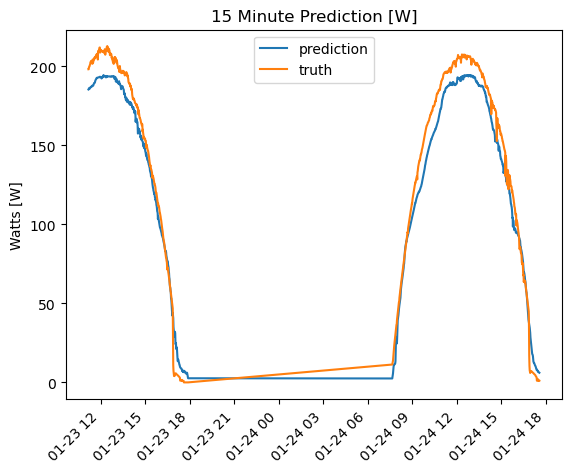

In [72]:
# Show sample of 15 minute look ahead
plt.plot(df_test_15['y_pred'].iloc[2000:3000], label='prediction')
plt.plot(df_test_15['y_truth'].iloc[2000:3000],  label='truth')
plt.title("15 Minute Prediction [W]")
plt.xticks(rotation=45, ha='right')
plt.ylabel("Watts [W]")
plt.legend()
plt.show()

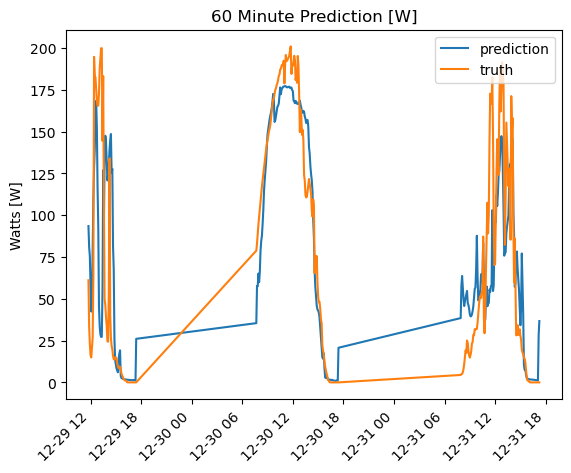

In [73]:
# Show sample of 60 minute look ahead
plt.plot(df_test_60['y_pred'].iloc[-300:], label='prediction')
plt.plot(df_test_60['y_truth'].iloc[-300:],  label='truth')
plt.title("60 Minute Prediction [W]")
plt.xticks(rotation=45, ha='right')
plt.ylabel("Watts [W]")
plt.legend()
plt.show()

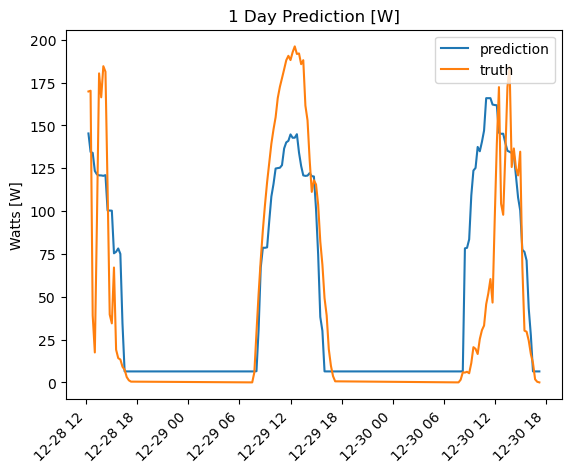

In [74]:
# Show sample of 1 day look ahead
plt.plot(df_test_1440['y_pred'].iloc[-100:], label='prediction')
plt.plot(df_test_1440['y_truth'].iloc[-100:],  label='truth')
plt.title("1 Day Prediction [W]")
plt.xticks(rotation=45, ha='right')
plt.ylabel("Watts [W]")
plt.legend()
plt.show()

In [75]:
# Output for dashboard
df_test_15.to_csv('lstm_15.csv')
df_test_60.to_csv('lstm_60.csv')
df_test_1440.to_csv('lstm_1440.csv')